In [1]:
#!pip install efficientnet_pytorch timm pretrainedmodels segmentation_models_pytorch pandas albumentations matplotlib colorama

In [2]:
import os
import shutil
import pathlib

from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
import cv2
from torch.cuda import amp

import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.utils import make_grid

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import segmentation_models_pytorch as smp
except:
    !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
    import albumentations as A
    import segmentation_models_pytorch as smp
    from albumentations.pytorch import ToTensorV2


In [3]:
#timm.list_models('*efficient*')

In [4]:
# device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [5]:
! ls -l ./contraildata/train/data_train/kaggle/working/data/ | wc -l
# Count of val records
! ls -l ./contraildata/validation/data_valid/kaggle/working/data_valid/ | wc -l

20530
1857


In [6]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'effb8modelv2fold0'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b8','efficientnet--r','efficientnet-b5'
    train_bs      = 16
    valid_bs      = train_bs
    img_size      = [512, 512]
    epochs        = 100
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.8
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [8]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.3),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
#        A.OneOf([
#            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#        ], p=0.25),
#        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
 #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.OneOf([
         #   A.HueSaturationValue(hue_shift_limit=0.5, sat_shift_limit=0.5, val_shift_limit=0.5, always_apply=False, p=1.0),
            A.Downscale(interpolation=cv2.INTER_NEAREST,p=1.0),
            A.Sharpen(p=1.0)
           # A.ChannelShuffle(p=1.0)
        ],
        p=0.5),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//10, max_width=CFG.img_size[1]//50,
                         min_holes=1, fill_value=0.35, mask_fill_value=0.35, p=0.6),
        ], p=1.0),
    

    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}


hard_data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [9]:
class Dataset:
    def __init__(self,mode,fold,transform =None,is_inference=True):
        
        self.is_infer = is_inference
        self.fold =fold
        ROOT_PATH = './contraildata/'

        df = pd.read_csv(f"{ROOT_PATH}/train_data_nir_folds.csv")

        
        if mode == 'train':
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/train/data_train/kaggle/working/data/'
            df =df.loc[df.fold != self.fold].copy().reset_index()
            
        elif mode =='valid':
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'
            df =df.loc[df.fold == self.fold].copy().reset_index()
        else :
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'

        self.images = df['image']
        self.labels = df['label']
        self.transform =transform
        
    def __getitem__(self, idx):
        image = np.load(self.images[idx]).astype(float)
        if not self.is_infer : 
            
            label = np.load(self.labels[idx]).astype(float)
            
            if  self.transform :
                data = self.transform(image=image, mask=label)
                image  = data['image']
                label  = data['mask']
                image = np.transpose(image, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))                
            return torch.tensor(image), torch.tensor(label)
        else :

            if  self.transform :
                data = self.transform(image=image)
                image  = data['image']
                image = np.transpose(image, (2, 0, 1))
            return torch.tensor(image)
    
    def __len__(self):
        return len(self.images)
    
train_dataset = Dataset('train',fold=0,transform =data_transforms['train'],is_inference=False)    
val_dataset = Dataset('valid',fold=0,transform =data_transforms['valid'],is_inference=False)    
test_dataset = Dataset('test',fold=0,transform =data_transforms['valid'],is_inference=True)    


In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(16423, 4106, 20529)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=2 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)

In [12]:
imgs, msks = next(iter(valid_loader))
imgs.size(), msks.size()

(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

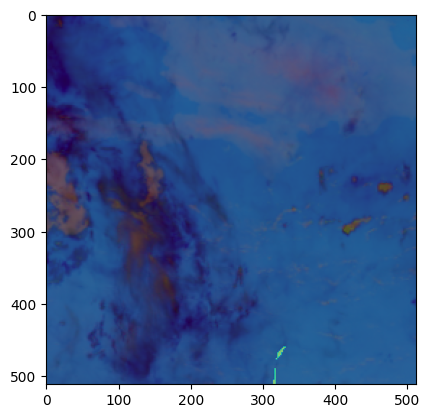

In [13]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img)
    
    if mask is not None:
        plt.imshow(mask, alpha=0.9)

    plt.axis('off')

plt.imshow(imgs[0,].permute((1, 2, 0)).numpy())
plt.imshow(msks[0].permute((1, 2, 0)).numpy(), alpha=0.5)

In [14]:
import timm as timm
def plot_batch(imgs, msks, size=5):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()
        #img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()
    


In [15]:
#timm.list_models("*efficientnet*")

In [16]:
#plot_batch(imgs,msks)

In [17]:
#encoder

In [18]:
import segmentation_models_pytorch as smp
import timm
n_blocks = 4

class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=True):
        super(TimmSegModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(12, 36, 3, stride=1, padding=1, bias=False)
        self.mybn1 = nn.BatchNorm2d(6)
        self.mybn2 = nn.BatchNorm2d(12)
        self.mybn3 = nn.BatchNorm2d(36)     
        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.8,
            drop_path_rate=0.5,
            pretrained=True
        )
#        self.encoder.conv_stem.weight = nn.Parameter(self.encoder.conv_stem.weight.repeat(1, 6, 1, 1))
        self.encoder.conv_stem=nn.Conv2d(6, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

        self.encoder.blocks[5] = nn.Identity()
        self.encoder.blocks[6] = nn.Sequential(
            nn.Conv2d(self.encoder.blocks[4][2].conv_pwl.out_channels, 320, 1),
            nn.BatchNorm2d(320),
            nn.ReLU6(),
        )
        tr = torch.randn(1,6,64,64)
        g = self.encoder(tr)
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unetplusplus.decoder.UnetPlusPlusDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], CFG.num_classes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        #print(x.shape)

        x = F.relu6(self.mybn1(self.conv1(x)))
#        x = F.relu6(self.mybn2(self.conv2(x)))
#        x = F.relu6(self.mybn3(self.conv3(x)))
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

#path='./exp/baselinev2/qishentrialv2_tf_efficientnet_b7_ns_last_epoch-00.bin'


def build_model(backbone):
    model = TimmSegModel(backbone,segtype='unet')
    model.to(CFG.device)
    return model

def load_model(path,backbone):
    model = build_model(backbone)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [19]:

##########################Anotha Banguh###########################
import segmentation_models_pytorch as smp
import timm
n_blocks = 4

n_blocks =4
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=True):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.5,
           # drop_path_rate=0.0,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 128, 128))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.decoders.unetplusplus.decoder.UnetPlusPlusDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(decoder_channels[n_blocks-1], 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.UpsamplingBilinear2d(scale_factor=1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features
    
#path='./exp/baselinev2/qishentrialv2_tf_efficientnet_b7_ns_last_epoch-00.bin'


def build_model(backbone):
    model = TimmSegModel(backbone,segtype='unet')
    model.to(CFG.device)
    return model

def load_model(path,backbone):
    model = build_model(backbone)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [20]:
#import timm
#timm.list_models('*efficientnet*')

In [21]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
DiceLoss    = smp.losses.DiceLoss(mode='binary')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=True)
TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

epsilon = 1e-5
smooth = 1
#DiceLoss=smp.utils.losses.DiceLoss()

def tversky(y_pred, y_true):
    y_true_pos = torch.flatten(y_true)
    y_pred_pos = torch.flatten(y_pred)
    true_pos = torch.sum(y_true_pos * y_pred_pos)
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos))
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

#def tversky_loss( y_pred,y_true):
#    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_pred,y_true):
    pt_1 = tversky(y_pred,y_true)
    gamma = 0.75
    return torch.pow((1-pt_1), gamma)
class Focal_Tversky():
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        #self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        #y_pr = self.activation(y_pr)
        return 1.0*focal_tversky(y_pr,y_gt)
    
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
        
    return dice

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>0.5).to(torch.float32)
    i = torch.sum(y_pred * y_true, dim=(2, 3))
    u = torch.sum(y_pred, dim=(2, 3)) + torch.sum(y_true, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    return torch.mean(score)

def dice_all(y_true, y_pred, smooth=1e-6):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred).to(torch.float32)
    i = torch.sum(y_pred * y_true)
    u = torch.sum(y_pred) + torch.sum(y_true)
    score = (2 * i + smooth)/(u + smooth)
    return score

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

def criterion2(y_pred, y_true):
    return LovaszLoss(y_pred, y_true)

In [22]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha=1.):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data,target,shuffled_target,lam

def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    #mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device)*data
    x2 = torch.from_numpy(1-mask).to(device)*shuffled_data
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets


def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        #masks = torch.nn.functional.interpolate(masks,size=256, mode='nearest')
        
        do_mixup = False
        mixing = random.random()
        #print(f"MIXING Value {mixing}")
        if mixing < 0.25:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        do_cutmix = False
        if (mixing>0.25) and (mixing <0.5) :
            do_cutmix = True
            images, masks, masks_sfl, lam = cutmix(images, masks)  
            
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images) 
            loss   = criterion(y_pred, masks) 
            loss   = loss / CFG.n_accumulate 
            if do_mixup: 
                loss2 = criterion(y_pred, masks_sfl) 
                loss = loss * lam  + loss2 * (1 - lam) 
            if do_cutmix: 
                loss2 = criterion(y_pred, masks_sfl) 
                loss = loss * lam  + loss2 * (1 - lam) 
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [23]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    masks_all =[]
    preds_all =[]
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
       # masks = torch.nn.functional.interpolate(masks,size=256, mode='nearest')
        masks_all.append(masks)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        preds_all.append(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_dice_mod = dice_score(masks, y_pred).cpu().detach().numpy()

        val_scores.append([val_dice, val_jaccard,val_dice_mod])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')

    predictions = torch.flatten(torch.stack(preds_all))
    ground_truth = torch.flatten(torch.stack(masks_all))

    val_corret_dice =dice_all(ground_truth,predictions).cpu().detach().numpy()
    val_scores  = np.mean(val_scores, axis=0)
    
    print(val_corret_dice)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores,val_corret_dice

In [24]:
# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

In [25]:
def run_training(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [26]:
from torch.optim import lr_scheduler

def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [27]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F') 

In [28]:
fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    
    
#run.finish()

tf_efficientnet_b8
cuda: NVIDIA A40

Start Training for Backbone ====> tf_efficientnet_b8
Epoch 1/100

Train :   0%|          | 4/1027 [00:07<21:28,  1.26s/it, gpu_mem=34.25 GB, lr=0.00100, train_loss=0.4402]  /tmp/ipykernel_1911/579482191.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
/tmp/ipykernel_1911/579482191.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

0.58100957
Valid Dice: 0.6876 | Valid Jaccard: 0.6261 | Valid Dice Mod: 0.6876
Valid Score Improved (-inf ---> 0.5810)
Model Saved


Epoch 2/100

Valid : 100%|██████████| 2053/2053 [01:44<00:00, 19.73it/s, gpu_memory=11.20 GB, lr=0.00100, valid_loss=0.1870]


0.5847422
Valid Dice: 0.6791 | Valid Jaccard: 0.6168 | Valid Dice Mod: 0.6791
Valid Score Improved (0.5810 ---> 0.5847)
Model Saved


Epoch 3/100

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.77it/s, gpu_memory=11.21 GB, lr=0.00100, valid_loss=0.1807]


0.6173657
Valid Dice: 0.7351 | Valid Jaccard: 0.6756 | Valid Dice Mod: 0.7351
Valid Score Improved (0.5847 ---> 0.6174)
Model Saved


Epoch 4/100

Valid : 100%|██████████| 2053/2053 [01:44<00:00, 19.67it/s, gpu_memory=11.08 GB, lr=0.00100, valid_loss=0.1749]


0.5993653
Valid Dice: 0.6927 | Valid Jaccard: 0.6284 | Valid Dice Mod: 0.6927


Epoch 5/100

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.84it/s, gpu_memory=11.19 GB, lr=0.00100, valid_loss=0.1790]


0.63422644
Valid Dice: 0.7538 | Valid Jaccard: 0.6962 | Valid Dice Mod: 0.7538
Valid Score Improved (0.6174 ---> 0.6342)
Model Saved


Epoch 6/100

Valid : 100%|██████████| 2053/2053 [01:54<00:00, 17.97it/s, gpu_memory=11.20 GB, lr=0.00100, valid_loss=0.1690]


0.63240725
Valid Dice: 0.7312 | Valid Jaccard: 0.6693 | Valid Dice Mod: 0.7312


Epoch 7/100

Valid :  85%|████████▌ | 1748/2053 [01:28<00:15, 19.84it/s, gpu_memory=9.84 GB, lr=0.00100, valid_loss=0.1654]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.87it/s, gpu_memory=11.07 GB, lr=0.00100, valid_loss=0.1673]


0.6242709
Valid Dice: 0.7402 | Valid Jaccard: 0.6779 | Valid Dice Mod: 0.7402


Epoch 9/100

Train :  70%|███████   | 723/1027 [07:11<03:09,  1.60it/s, gpu_mem=36.38 GB, lr=0.00100, train_loss=0.1787]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.90it/s, gpu_memory=10.96 GB, lr=0.00100, valid_loss=0.1671]


0.6330404
Valid Dice: 0.7250 | Valid Jaccard: 0.6622 | Valid Dice Mod: 0.7250


Epoch 16/100

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.87it/s, gpu_memory=11.23 GB, lr=0.00100, valid_loss=0.1594]


0.64743567
Valid Dice: 0.7232 | Valid Jaccard: 0.6597 | Valid Dice Mod: 0.7232
Valid Score Improved (0.6432 ---> 0.6474)
Model Saved


Epoch 17/100

Valid : 100%|██████████| 2053/2053 [01:43<00:00, 19.91it/s, gpu_memory=11.25 GB, lr=0.00099, valid_loss=0.1602]


0.645896
Valid Dice: 0.7373 | Valid Jaccard: 0.6739 | Valid Dice Mod: 0.7373


Epoch 18/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.25 GB, lr=0.00098, valid_loss=0.1560]


0.657739
Valid Dice: 0.7398 | Valid Jaccard: 0.6767 | Valid Dice Mod: 0.7398


Epoch 31/100

Valid :  49%|████▉     | 1008/2053 [00:50<00:51, 20.14it/s, gpu_memory=6.61 GB, lr=0.00098, valid_loss=0.1580]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.25 GB, lr=0.00098, valid_loss=0.1628]


0.6283959
Valid Dice: 0.7211 | Valid Jaccard: 0.6568 | Valid Dice Mod: 0.7211


Epoch 34/100

Train :  11%|█         | 111/1027 [01:06<08:35,  1.78it/s, gpu_mem=36.77 GB, lr=0.00098, train_loss=0.1722]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.03it/s, gpu_memory=11.28 GB, lr=0.00098, valid_loss=0.1549]


0.6532287
Valid Dice: 0.7176 | Valid Jaccard: 0.6535 | Valid Dice Mod: 0.7176


Epoch 36/100

Train :  78%|███████▊  | 803/1027 [07:43<02:09,  1.72it/s, gpu_mem=36.83 GB, lr=0.00098, train_loss=0.1748]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid :  52%|█████▏    | 1059/2053 [00:52<00:48, 20.32it/s, gpu_memory=6.83 GB, lr=0.00097, valid_loss=0.1560]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid :  95%|█████████▍| 1947/2053 [01:36<00:05, 20.02it/s, gpu_memory=10.79 GB, lr=0.00097, valid_loss=0.1561]IOPub message rate exc

0.6596516
Valid Dice: 0.7444 | Valid Jaccard: 0.6815 | Valid Dice Mod: 0.7444


Epoch 43/100

Train :  85%|████████▍ | 872/1027 [08:40<01:34,  1.64it/s, gpu_mem=36.80 GB, lr=0.00097, train_loss=0.1746]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.12it/s, gpu_memory=11.27 GB, lr=0.00096, valid_loss=0.1519]


0.66346514
Valid Dice: 0.7570 | Valid Jaccard: 0.6939 | Valid Dice Mod: 0.7570


Epoch 45/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.10it/s, gpu_memory=11.25 GB, lr=0.00096, valid_loss=0.1549]


0.65506864
Valid Dice: 0.7365 | Valid Jaccard: 0.6734 | Valid Dice Mod: 0.7365


Epoch 46/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.30 GB, lr=0.00096, valid_loss=0.1505]


0.67010915
Valid Dice: 0.7632 | Valid Jaccard: 0.7008 | Valid Dice Mod: 0.7632
Valid Score Improved (0.6672 ---> 0.6701)
Model Saved


Epoch 47/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.30 GB, lr=0.00096, valid_loss=0.1562]


0.65360004
Valid Dice: 0.7428 | Valid Jaccard: 0.6798 | Valid Dice Mod: 0.7428


Epoch 48/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.33 GB, lr=0.00096, valid_loss=0.1554]


0.66360825
Valid Dice: 0.7601 | Valid Jaccard: 0.6983 | Valid Dice Mod: 0.7601


Epoch 49/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.06it/s, gpu_memory=11.29 GB, lr=0.00096, valid_loss=0.1528]


0.6601843
Valid Dice: 0.7496 | Valid Jaccard: 0.6861 | Valid Dice Mod: 0.7496


Epoch 50/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.31 GB, lr=0.00095, valid_loss=0.1536]


0.66094744
Valid Dice: 0.7585 | Valid Jaccard: 0.6957 | Valid Dice Mod: 0.7585


Epoch 51/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.03it/s, gpu_memory=11.28 GB, lr=0.00095, valid_loss=0.1579]


0.66228837
Valid Dice: 0.7672 | Valid Jaccard: 0.7065 | Valid Dice Mod: 0.7672


Epoch 52/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.28 GB, lr=0.00095, valid_loss=0.1536]


0.6701313
Valid Dice: 0.7649 | Valid Jaccard: 0.7032 | Valid Dice Mod: 0.7649
Valid Score Improved (0.6701 ---> 0.6701)
Model Saved


Epoch 53/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.03it/s, gpu_memory=11.26 GB, lr=0.00095, valid_loss=0.1543]


0.661068
Valid Dice: 0.7606 | Valid Jaccard: 0.6985 | Valid Dice Mod: 0.7606


Epoch 54/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.30 GB, lr=0.00095, valid_loss=0.1546]


0.6621682
Valid Dice: 0.7659 | Valid Jaccard: 0.7036 | Valid Dice Mod: 0.7659


Epoch 55/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.31 GB, lr=0.00095, valid_loss=0.1507]


0.6692767
Valid Dice: 0.7620 | Valid Jaccard: 0.6997 | Valid Dice Mod: 0.7620


Epoch 56/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.26 GB, lr=0.00094, valid_loss=0.1518]


0.66634125
Valid Dice: 0.7575 | Valid Jaccard: 0.6952 | Valid Dice Mod: 0.7575


Epoch 57/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.28 GB, lr=0.00094, valid_loss=0.1534]


0.6639529
Valid Dice: 0.7524 | Valid Jaccard: 0.6901 | Valid Dice Mod: 0.7524


Epoch 58/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.03it/s, gpu_memory=11.27 GB, lr=0.00094, valid_loss=0.1560]


0.6602569
Valid Dice: 0.7700 | Valid Jaccard: 0.7083 | Valid Dice Mod: 0.7700


Epoch 59/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.29 GB, lr=0.00094, valid_loss=0.1506]


0.6724789
Valid Dice: 0.7667 | Valid Jaccard: 0.7045 | Valid Dice Mod: 0.7667
Valid Score Improved (0.6701 ---> 0.6725)
Model Saved


Epoch 60/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.30 GB, lr=0.00094, valid_loss=0.1570]


0.667571
Valid Dice: 0.7679 | Valid Jaccard: 0.7075 | Valid Dice Mod: 0.7679


Epoch 61/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.30 GB, lr=0.00093, valid_loss=0.1502]


0.67315364
Valid Dice: 0.7702 | Valid Jaccard: 0.7081 | Valid Dice Mod: 0.7702
Valid Score Improved (0.6725 ---> 0.6732)
Model Saved


Epoch 62/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.26 GB, lr=0.00093, valid_loss=0.1576]


0.66156095
Valid Dice: 0.7721 | Valid Jaccard: 0.7114 | Valid Dice Mod: 0.7721


Epoch 63/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.06it/s, gpu_memory=11.19 GB, lr=0.00093, valid_loss=0.1528]


0.6694834
Valid Dice: 0.7688 | Valid Jaccard: 0.7068 | Valid Dice Mod: 0.7688


Epoch 64/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.28 GB, lr=0.00093, valid_loss=0.1534]


0.65653765
Valid Dice: 0.7376 | Valid Jaccard: 0.6739 | Valid Dice Mod: 0.7376


Epoch 65/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.24 GB, lr=0.00092, valid_loss=0.1510]


0.6726141
Valid Dice: 0.7612 | Valid Jaccard: 0.6990 | Valid Dice Mod: 0.7612


Epoch 66/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.06it/s, gpu_memory=11.30 GB, lr=0.00092, valid_loss=0.1510]


0.66935164
Valid Dice: 0.7635 | Valid Jaccard: 0.7013 | Valid Dice Mod: 0.7635


Epoch 67/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.27 GB, lr=0.00092, valid_loss=0.1560]


0.66069925
Valid Dice: 0.7628 | Valid Jaccard: 0.7013 | Valid Dice Mod: 0.7628


Epoch 68/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.06it/s, gpu_memory=11.27 GB, lr=0.00092, valid_loss=0.1522]


0.6738042
Valid Dice: 0.7628 | Valid Jaccard: 0.7010 | Valid Dice Mod: 0.7628
Valid Score Improved (0.6732 ---> 0.6738)
Model Saved


Epoch 69/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.28 GB, lr=0.00091, valid_loss=0.1519]


0.67138165
Valid Dice: 0.7635 | Valid Jaccard: 0.7016 | Valid Dice Mod: 0.7635


Epoch 70/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.28 GB, lr=0.00091, valid_loss=0.1527]


0.6749798
Valid Dice: 0.7707 | Valid Jaccard: 0.7095 | Valid Dice Mod: 0.7707
Valid Score Improved (0.6738 ---> 0.6750)
Model Saved


Epoch 71/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.24 GB, lr=0.00091, valid_loss=0.1566]


0.6601381
Valid Dice: 0.7675 | Valid Jaccard: 0.7057 | Valid Dice Mod: 0.7675


Epoch 72/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.12it/s, gpu_memory=11.27 GB, lr=0.00091, valid_loss=0.1520]


0.66697264
Valid Dice: 0.7589 | Valid Jaccard: 0.6958 | Valid Dice Mod: 0.7589


Epoch 73/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.19 GB, lr=0.00090, valid_loss=0.1517]


0.66904765
Valid Dice: 0.7537 | Valid Jaccard: 0.6913 | Valid Dice Mod: 0.7537


Epoch 74/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.32 GB, lr=0.00090, valid_loss=0.1533]


0.67105544
Valid Dice: 0.7683 | Valid Jaccard: 0.7072 | Valid Dice Mod: 0.7683


Epoch 75/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.28 GB, lr=0.00090, valid_loss=0.1539]


0.6670395
Valid Dice: 0.7606 | Valid Jaccard: 0.6987 | Valid Dice Mod: 0.7606


Epoch 76/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.30 GB, lr=0.00090, valid_loss=0.1581]


0.67014015
Valid Dice: 0.7801 | Valid Jaccard: 0.7201 | Valid Dice Mod: 0.7801


Epoch 77/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.10it/s, gpu_memory=11.26 GB, lr=0.00089, valid_loss=0.1517]


0.66490686
Valid Dice: 0.7421 | Valid Jaccard: 0.6789 | Valid Dice Mod: 0.7421


Epoch 78/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.10it/s, gpu_memory=11.26 GB, lr=0.00089, valid_loss=0.1534]


0.6746121
Valid Dice: 0.7784 | Valid Jaccard: 0.7178 | Valid Dice Mod: 0.7784


Epoch 79/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.30 GB, lr=0.00089, valid_loss=0.1567]


0.6662531
Valid Dice: 0.7696 | Valid Jaccard: 0.7090 | Valid Dice Mod: 0.7696


Epoch 80/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.11it/s, gpu_memory=11.30 GB, lr=0.00089, valid_loss=0.1540]


0.6651756
Valid Dice: 0.7627 | Valid Jaccard: 0.7002 | Valid Dice Mod: 0.7627


Epoch 81/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.13it/s, gpu_memory=11.24 GB, lr=0.00088, valid_loss=0.1497]


0.6765421
Valid Dice: 0.7704 | Valid Jaccard: 0.7080 | Valid Dice Mod: 0.7704
Valid Score Improved (0.6750 ---> 0.6765)
Model Saved


Epoch 82/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.09it/s, gpu_memory=11.28 GB, lr=0.00088, valid_loss=0.1495]


0.6646461
Valid Dice: 0.7346 | Valid Jaccard: 0.6708 | Valid Dice Mod: 0.7346


Epoch 83/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.27 GB, lr=0.00088, valid_loss=0.1514]


0.6684699
Valid Dice: 0.7538 | Valid Jaccard: 0.6913 | Valid Dice Mod: 0.7538


Epoch 84/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.30 GB, lr=0.00088, valid_loss=0.1556]


0.6546029
Valid Dice: 0.7557 | Valid Jaccard: 0.6927 | Valid Dice Mod: 0.7557


Epoch 85/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.26 GB, lr=0.00087, valid_loss=0.1542]


0.6584199
Valid Dice: 0.7623 | Valid Jaccard: 0.6992 | Valid Dice Mod: 0.7623


Epoch 87/100

Valid : 100%|██████████| 2053/2053 [01:41<00:00, 20.13it/s, gpu_memory=11.25 GB, lr=0.00087, valid_loss=0.1496]


0.6700772
Valid Dice: 0.7581 | Valid Jaccard: 0.6949 | Valid Dice Mod: 0.7581


Epoch 88/100

Train :  28%|██▊       | 291/1027 [02:51<07:00,  1.75it/s, gpu_mem=36.59 GB, lr=0.00087, train_loss=0.1652]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.27 GB, lr=0.00086, valid_loss=0.1562]


0.6691851
Valid Dice: 0.7650 | Valid Jaccard: 0.7044 | Valid Dice Mod: 0.7650


Epoch 89/100

Train :  32%|███▏      | 326/1027 [03:15<06:48,  1.72it/s, gpu_mem=36.51 GB, lr=0.00086, train_loss=0.1719]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.11it/s, gpu_memory=11.32 GB, lr=0.00086, valid_loss=0.1503]


0.6732957
Valid Dice: 0.7724 | Valid Jaccard: 0.7106 | Valid Dice Mod: 0.7724


Epoch 90/100

Train :  17%|█▋        | 173/1027 [01:43<08:23,  1.70it/s, gpu_mem=36.60 GB, lr=0.00086, train_loss=0.1724]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.05it/s, gpu_memory=11.27 GB, lr=0.00086, valid_loss=0.1506]


0.66943246
Valid Dice: 0.7617 | Valid Jaccard: 0.6993 | Valid Dice Mod: 0.7617


Epoch 91/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.07it/s, gpu_memory=11.26 GB, lr=0.00085, valid_loss=0.1524]


0.66717726
Valid Dice: 0.7688 | Valid Jaccard: 0.7068 | Valid Dice Mod: 0.7688


Epoch 92/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.08it/s, gpu_memory=11.26 GB, lr=0.00085, valid_loss=0.1496]


0.6701124
Valid Dice: 0.7427 | Valid Jaccard: 0.6800 | Valid Dice Mod: 0.7427


Epoch 93/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.06it/s, gpu_memory=11.30 GB, lr=0.00085, valid_loss=0.1547]


0.653198
Valid Dice: 0.7577 | Valid Jaccard: 0.6949 | Valid Dice Mod: 0.7577


Epoch 94/100

Valid :  85%|████████▍ | 1743/2053 [01:26<00:15, 20.17it/s, gpu_memory=9.94 GB, lr=0.00085, valid_loss=0.1564]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.01it/s, gpu_memory=11.30 GB, lr=0.00084, valid_loss=0.1523]


0.67012036
Valid Dice: 0.7620 | Valid Jaccard: 0.7001 | Valid Dice Mod: 0.7620


Epoch 96/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.01it/s, gpu_memory=11.26 GB, lr=0.00084, valid_loss=0.1506]


0.66561073
Valid Dice: 0.7594 | Valid Jaccard: 0.6966 | Valid Dice Mod: 0.7594


Epoch 97/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.25 GB, lr=0.00084, valid_loss=0.1600]


0.6403095
Valid Dice: 0.7450 | Valid Jaccard: 0.6818 | Valid Dice Mod: 0.7450


Epoch 98/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.32 GB, lr=0.00083, valid_loss=0.1513]


0.67262924
Valid Dice: 0.7616 | Valid Jaccard: 0.6994 | Valid Dice Mod: 0.7616


Epoch 99/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.01it/s, gpu_memory=11.26 GB, lr=0.00083, valid_loss=0.1550]


0.670622
Valid Dice: 0.7714 | Valid Jaccard: 0.7106 | Valid Dice Mod: 0.7714


Epoch 100/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.04it/s, gpu_memory=11.31 GB, lr=0.00083, valid_loss=0.1521]


0.665519
Valid Dice: 0.7601 | Valid Jaccard: 0.6979 | Valid Dice Mod: 0.7601


Training complete in 19h 41m 48s
Best Score: 0.7080
efficientnet--r


RuntimeError: Unknown model (efficientnet--r)

In [ ]:
bla

In [29]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'effb8modelv3fold0'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b8','efficientnet--r','efficientnet-b5'
    train_bs      = 16
    valid_bs      = train_bs
    img_size      = [512, 512]
    epochs        = 100
    lr            = 1e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
###Stage2 :
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_one_epochstage2(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion2(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            if do_mixup:
                loss2 = criterion(y_pred, masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss


In [31]:
def criterion2(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

In [32]:
def run_trainingstage2(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epochstage2(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_correct_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epochstage2-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epochstage2-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=2 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs//2, 
                              num_workers=4, shuffle=False, pin_memory=True)

fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./effb8modelv2fold0_tf_efficientnet_b8_best_epoch-00.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage2(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

tf_efficientnet_b8
cuda: NVIDIA A40

Start Training for Backbone ====> tf_efficientnet_b8
Epoch 1/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.02it/s, gpu_memory=10.88 GB, lr=0.00010, valid_loss=0.1518]


0.6919087
Valid Dice: 0.6919 | Valid Jaccard: 0.7214 | Valid Dice Mod: 0.7831
Valid Score Improved (-inf ---> 0.6919)
Model Saved


Epoch 2/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 19.97it/s, gpu_memory=11.17 GB, lr=0.00010, valid_loss=0.1528]


0.6934504
Valid Dice: 0.6935 | Valid Jaccard: 0.7163 | Valid Dice Mod: 0.7780
Valid Score Improved (0.6919 ---> 0.6935)
Model Saved


Epoch 3/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.00it/s, gpu_memory=11.24 GB, lr=0.00010, valid_loss=0.1536]


0.6937175
Valid Dice: 0.6937 | Valid Jaccard: 0.7205 | Valid Dice Mod: 0.7818
Valid Score Improved (0.6935 ---> 0.6937)
Model Saved


Epoch 4/100

Valid :  84%|████████▍ | 1727/2053 [01:26<00:16, 20.01it/s, gpu_memory=9.70 GB, lr=0.00010, valid_loss=0.1562]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 19.96it/s, gpu_memory=10.89 GB, lr=0.00010, valid_loss=0.1571]


0.69366133
Valid Dice: 0.6937 | Valid Jaccard: 0.7209 | Valid Dice Mod: 0.7825


Epoch 6/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.02it/s, gpu_memory=11.31 GB, lr=0.00010, valid_loss=0.1589]


0.6932687
Valid Dice: 0.6933 | Valid Jaccard: 0.7268 | Valid Dice Mod: 0.7876


Epoch 7/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.01it/s, gpu_memory=11.10 GB, lr=0.00010, valid_loss=0.1568]


0.6939057
Valid Dice: 0.6939 | Valid Jaccard: 0.7171 | Valid Dice Mod: 0.7788


Epoch 8/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 19.99it/s, gpu_memory=11.17 GB, lr=0.00010, valid_loss=0.1589]


0.6939078
Valid Dice: 0.6939 | Valid Jaccard: 0.7228 | Valid Dice Mod: 0.7840


Epoch 9/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.00it/s, gpu_memory=11.16 GB, lr=0.00010, valid_loss=0.1602]


0.6943686
Valid Dice: 0.6944 | Valid Jaccard: 0.7222 | Valid Dice Mod: 0.7836
Valid Score Improved (0.6940 ---> 0.6944)
Model Saved


Epoch 10/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 20.01it/s, gpu_memory=11.23 GB, lr=0.00010, valid_loss=0.1600]


0.6933353
Valid Dice: 0.6933 | Valid Jaccard: 0.7203 | Valid Dice Mod: 0.7818


Epoch 11/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 19.99it/s, gpu_memory=11.18 GB, lr=0.00010, valid_loss=0.1578]


0.6949684
Valid Dice: 0.6950 | Valid Jaccard: 0.7211 | Valid Dice Mod: 0.7823
Valid Score Improved (0.6944 ---> 0.6950)
Model Saved


Epoch 12/100

Valid : 100%|██████████| 2053/2053 [01:42<00:00, 19.93it/s, gpu_memory=11.11 GB, lr=0.00010, valid_loss=0.1605]


0.69277436
Valid Dice: 0.6928 | Valid Jaccard: 0.7152 | Valid Dice Mod: 0.7770


Epoch 13/100

Train :  78%|███████▊  | 801/1027 [07:49<02:05,  1.79it/s, gpu_mem=36.68 GB, lr=0.00010, train_loss=0.1850]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=16 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs//2, 
                              num_workers=4, shuffle=False, pin_memory=True)

fold =0
from tqdm import tqdm
import time
import copy;
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./exp/effb8modelv2_tf_efficientnet_b8_best_epochstage2-00cv675.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage2(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

In [ ]:
####STAGE 3 

In [ ]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'qishentrialv384unetplus'
    comment       = 'unet-effb0-256x256-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'tf_efficientnet_b7_ns','efficientnet--r','efficientnet-b5'
    train_bs      = 12
    valid_bs      = train_bs
    img_size      = [384, 384]
    epochs        = 1
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 1
    p_mixup         =0.0
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
###Stage2 :
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_one_epochstage3(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        do_mixup = False
        if random.random() < CFG.p_mixup:
            do_mixup = True
            images, masks, masks_sfl, lam = mixup(images, masks)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion2(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            if do_mixup:
                loss2 = criterion(y_pred, masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss


In [ ]:
def train_csv(x,path):
    y= x.replace("/kaggle/working/data/",f"{path}")
    return y

class Dataset:
    def __init__(self,mode,transform =None,is_inference=True):
        
        self.is_infer = is_inference

        
        if mode == 'train':
            ROOT_PATH = './contraildata/train'
            DATA_PATH = './contraildata/train/data_train/kaggle/working/data/'
        elif mode =='valid':
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'
        elif mode == 'all' :
            ROOT_PATH = './contraildata/all'
            DATA_PATH = './contraildata/all/'
            
        else :
            ROOT_PATH = './contraildata/'
            DATA_PATH = './contraildata/validation/data_valid/kaggle/working/data_valid/'
            
        if mode =='all':
            
            df = pd.read_csv(f"{ROOT_PATH}/data_all.csv")
            
        else:

            df = pd.read_csv(f"{ROOT_PATH}/data.csv")
        
            df["image"]=df["image"].apply(lambda x: train_csv(x,DATA_PATH))
        
            if not (self.is_infer):
                df["label"]=df["label"].apply(lambda x:train_csv(x,DATA_PATH))

        self.images = df['image']
        self.labels = df['label']
        self.transform =transform
    def __getitem__(self, idx):
        image = np.load(self.images[idx]).astype(float)
        if not self.is_infer : 
            
            label = np.load(self.labels[idx]).astype(float)
            
            if  self.transform :
                data = self.transform(image=image, mask=label)
                image  = data['image']
                label  = data['mask']
                image = np.transpose(image, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))                
            return torch.tensor(image), torch.tensor(label)
        else :

            if  self.transform :
                data = self.transform(image=image)
                image  = data['image']
                image = np.transpose(image, (2, 0, 1))
            return torch.tensor(image)
    
    def __len__(self):
        return len(self.images)
    
train_dataset = Dataset('train',transform =data_transforms['train'],is_inference=False)    
val_dataset = Dataset('valid',transform =data_transforms['valid'],is_inference=False)    
all_dataset = Dataset('all',transform =data_transforms['train'],is_inference=False)    

test_dataset = Dataset('test',transform =data_transforms['valid'],is_inference=True)    

train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)

all_loader = DataLoader(all_dataset, batch_size=8 , 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=4 , 
                              num_workers=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
def run_trainingstage3(model,backbone, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
   # wandb.watch(model, log_freq=100)
    fold =0
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
        
    print(f"Start Training for Backbone ====> {backbone}")
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epochstage3(model, optimizer, scheduler, 
                                           dataloader=all_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores,val_correct_dice = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard,val_dice_mod = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_correct_dice)
        history['Valid Jaccard'].append(val_jaccard)
        history['Valid Dice Mod'].append(val_dice_mod)

        
        # Log the metrics
 #       wandb.log({"Train Loss": train_loss, 
 #                  "Valid Loss": val_loss,
 #                  "Valid Dice": val_dice,
 #                  "Valid Jaccard": val_jaccard,
 #                  "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_correct_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | Valid Dice Mod: {val_dice_mod:0.4f}')
        
        # deep copy the model
        if val_correct_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_correct_dice:0.4f})")
            best_dice    = val_correct_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
            #run.summary["Best Jaccard"] = best_jaccard
            #run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.exp_name}_{backbone}_best_epochstage3-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            #wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.exp_name}_{backbone}_last_epochstage3-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
fold =0
from tqdm import tqdm
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
path='./qishentrialv384unetplus_tf_efficientnet_b7_ns_best_epochstage2-00.bin'

for backbone in CFG.backbone :
    print(backbone)
    model     = build_model(backbone)
    model =load_model(path,backbone)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_trainingstage3(model,backbone, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)

In [ ]:
backbones =['efficientnet_b0']


In [ ]:
%%time
out_rle=[]

preds = []
truth= []
preds_all =[]
truth_all =[]
preds_new=[]
for index,(imgs,msks) in enumerate(valid_loader):
        imgs = imgs.to(CFG.device, dtype=torch.float)
        msks = msks.to(CFG.device, dtype=torch.float)
        pred_bb=0
        for backbone in backbones:
            model = load_model("qishentrial_efficientnet-b0_best_epoch-00.bin",backbone)
            with torch.no_grad():
                pred = model(imgs)
                pred_bb+=pred
        pred = (nn.Sigmoid()(pred_bb/len(backbones))>0.5).double()
        preds.append(pred)
        preds_new.append(pred.cpu().detach())
imgs  = imgs.cpu().detach()
msks  =msks.cpu().detach()

preds_new = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
#truth = torch.mean(torch.stack(msks, dim=0), dim=0).cpu().detach()


#out_reversed = np.array([o.cpu().permute(1,2,0).numpy() for o in preds])
#for e in out_reversed:
#    out_rle.append(e)

In [ ]:
pred_bb =torch.randn(64,1,512,512)

cv2.resize(pred_bb[0].numpy().reshape(512,512),(256,256),interpolation=cv2.INTER_NEAREST).shape

In [ ]:
backbone=['efficientnet_b0']
imgs,msks = next(iter(valid_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)
out_rle=[]

preds = []
for fold in range(1):
    
    for bb in backbone:
        
        model = load_model(f"qishentrial_efficientnet-b0_best_epoch-00.bin",bb)
        with torch.no_grad():
            pred_tmp = model(imgs)
            pred+=pred_tmp
    pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

out_reversed = np.array([o.cpu().permute(1,2,0).numpy() for o in preds])
for e in out_reversed:
    out_rle.append(e)

In [ ]:
def resizeMask(mask, w, h):
    
    resmask = np.zeros((h, w, mask.shape[2]))
    for i in range(mask.shape[2]):
        resmask[...,i] = cv2.resize(mask[...,i], (w,h))
        
    return resmask

In [ ]:
b,c,h,w =preds.shape

def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))

In [ ]:
msks

In [ ]:
plot_batch(imgs, preds, size=2)

In [ ]:
plot_batch(imgs, msks, size=5)